# MonReader

In [2]:
#Load Libraries
import os, sys, random, warnings
from pathlib import Path
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

In [3]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

# Directory
dir = "/content/drive/MyDrive/Personal/Apziva/images"

# Setting random state for consistency
seed = 123
np.random.seed(seed)

# Confirm GPU


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mounted at /content/drive
Wed Nov 12 14:11:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+---------------------

## Loading and Resizing Photos

In [4]:
# Params
IMG_WIDTH  = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_NOT   = f"{dir}/training/notflip"
TRAIN_FLIP  = f"{dir}/training/flip"
TEST_NOT    = f"{dir}/testing/notflip"
TEST_FLIP   = f"{dir}/testing/flip"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [5]:
import os
print(os.path.exists(TRAIN_NOT))
print(os.path.exists(TRAIN_FLIP))
print(os.path.exists(TEST_NOT))
print(os.path.exists(TEST_FLIP))


True
True
True
True


In [6]:
def _list_images(p):
    p = Path(p)
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")
    files = []
    for e in exts:
        files += list(p.rglob(e))   # works whether images are directly inside or nested per-id
    return sorted(files)

def _load_and_resize(path):
    img = imread(str(path))[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True, anti_aliasing=True)
    return img.astype(np.uint8)

def load_binary_split():
    # Collect file paths and labels
    train_paths = _list_images(TRAIN_NOT)
    train_labels = [0]*len(train_paths)
    fp = _list_images(TRAIN_FLIP)
    train_paths += fp
    train_labels += [1]*len(fp)

    test_paths  = _list_images(TEST_NOT)
    test_labels = [0]*len(test_paths)
    fp = _list_images(TEST_FLIP)
    test_paths += fp
    test_labels += [1]*len(fp)

    # Shuffle deterministically
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(train_paths))
    train_paths = [train_paths[i] for i in idx]
    train_labels = np.array([train_labels[i] for i in idx], dtype=np.int32)

    idx = rng.permutation(len(test_paths))
    test_paths = [test_paths[i] for i in idx]
    test_labels = np.array([test_labels[i] for i in idx], dtype=np.int32)

    # Load pixels
    print("Loading and resizing training images...")
    X_train = np.zeros((len(train_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    for i, p in tqdm(list(enumerate(train_paths)), total=len(train_paths)):
        X_train[i] = _load_and_resize(p)

    print("Loading and resizing test images...")
    X_test = np.zeros((len(test_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    for i, p in tqdm(list(enumerate(test_paths)), total=len(test_paths)):
        X_test[i] = _load_and_resize(p)

    # Scale to [0,1] floats for CNN input
    X_train = (X_train / 255.0).astype(np.float32)
    X_test  = (X_test  / 255.0).astype(np.float32)

    return X_train, train_labels, X_test, test_labels, train_paths, test_paths

X_train, y_train, X_test, y_test, train_files, test_files = load_binary_split()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Loading and resizing training images...


100%|██████████| 2392/2392 [23:36<00:00,  1.69it/s]


Loading and resizing test images...


100%|██████████| 597/597 [06:59<00:00,  1.42it/s]


(2392, 128, 128, 3) (2392,) (597, 128, 128, 3) (597,)


In [7]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2392, 128, 128, 3) (2392,) (597, 128, 128, 3) (597,)


In [8]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.1 MB/s eta 0:00:00


In [19]:
# Keras Tuner template for your 2D CNN
# pip install keras-tuner if needed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import keras_tuner as kt
import numpy as np

# Optional: set seed
tf.keras.utils.set_random_seed(42)

# Derive input shape from data if available; else fall back to your constants

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

def build_model(hp: kt.HyperParameters) -> keras.Model:
    # Search space
    hp_filters1 = hp.Choice("filters_1", values=[16, 32, 48, 64])
    hp_filters2 = hp.Choice("filters_2", values=[32, 64, 96, 128])
    hp_filters3 = hp.Choice("filters_3", values=[64, 96, 128, 192])
    hp_kernel   = hp.Choice("kernel_size", values=[3, 5])
    hp_dropout  = hp.Float("dropout", min_value=0.1, max_value=0.6, step=0.1)
    hp_dense    = hp.Choice("dense_units", values=[32, 64, 128, 256])
    hp_lr       = hp.Choice("learning_rate", values=[1e-4, 3e-4, 1e-3, 3e-3])

    m = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(hp_filters1, hp_kernel, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(hp_filters2, hp_kernel, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(hp_filters3, hp_kernel, padding="same", activation="relu"),
        layers.GlobalAveragePooling2D(),

        layers.Dropout(hp_dropout),
        layers.Dense(hp_dense, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc")
        ],
    )
    return m

# Choose a tuner. HyperBand is fast and solid for CNNs.
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_auc", direction="max"),  # tune on AUC for imbalanced data
    max_epochs=30,
    factor=3,
    directory="kt_cnn_runs",
    project_name="flip_detector"
)

# Optional callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=5, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6
)

# Batch size as a hyperparameter
batch_size_hp = kt.HyperParameters()
# You can also search batch size; here we pass choices via fit kwargs using lambda:
def hp_batch_size(hp):
    return hp.Choice("batch_size", values=[16, 32, 64])

# Launch search
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    batch_size=hp_batch_size(tuner.oracle.hyperparameters)
)

# Get best model and train a final fit if desired
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hp)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=best_hp.get("batch_size", 32),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
eval_out = model.evaluate(X_test, y_test, verbose=0)
print({"loss": eval_out[0], "acc": eval_out[1], "auc": eval_out[2]})


Trial 84 Complete [00h 00m 43s]
val_auc: 0.9727957248687744

Best val_auc So Far: 0.9985173940658569
Total elapsed time: 00h 23m 40s


TypeError: HyperParameters.get() takes 2 positional arguments but 3 were given

In [21]:
import keras_tuner as kt
from tensorflow import keras

# 1) Recreate the tuner with the SAME directory/project (do NOT set overwrite=True)
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_auc", "max"),
    max_epochs=30,
    factor=3,
    directory="kt_cnn_runs",
    project_name="flip_detector",
)

# 2) Quick summaries of what was recovered
tuner.search_space_summary()
tuner.results_summary(num_trials=10)

# 3) Best-so-far hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)                 # dict of all params
print(best_hp.get("filters_1"))       # single value
print(best_hp.get("batch_size", 32))  # if you searched batch_size

# 4) Build best model and verify optimizer LR chosen
best_model = tuner.hypermodel.build(best_hp)
print("LR:", best_model.optimizer.learning_rate.numpy())

# 5) Get a ranked table of completed trials (score = objective on val data)
rows = []
for tr in tuner.oracle.get_best_trials(num_trials=100):
    r = dict(tr.hyperparameters.values)
    r["score"] = tr.score
    rows.append(r)

# Optional: pretty table with pandas
try:
    import pandas as pd
    df = pd.DataFrame(rows).sort_values("score", ascending=False)
    print(df.head(10))
except ImportError:
    for r in rows[:10]:
        print(r)


Reloading Tuner from kt_cnn_runs/flip_detector/tuner0.json
Search space summary
Default search space size: 8
filters_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 48, 64], 'ordered': True}
filters_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 96, 128], 'ordered': True}
filters_3 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 96, 128, 192], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
dense_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.0003, 0.001, 0.003], 'ordered': True}
batch_size (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
Results summary
Results in kt_cnn_runs/flip_detector
Showing 10 be

TypeError: HyperParameters.get() takes 2 positional arguments but 3 were given

In [ ]:
filters_1: 48
filters_2: 96
filters_3: 96
kernel_size: 5
dropout: 0.1
dense_units: 128
learning_rate: 0.001
batch_size: 16
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0071
Score: 0.99851739406585

In [22]:
from tensorflow.keras import layers, models

def build_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(48, 5, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(96, 5, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(96, 5, activation="relu"),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.1),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc"),
                       tf.keras.metrics.F1Score( name='f1_score')])
    return m

model = build_cnn()



In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 124, 124, 48)   │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 58, 58, 96)     │       115,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 29, 29, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 96)     │       230,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,985 (1.38 MB)

 Trainable params: 361,985 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,
    verbose=1
)

Epoch 1/30


ValueError: FBetaScore expects 2D inputs with shape (batch_size, output_dim). Received input shapes: y_pred.shape=(None, 1) and y_true.shape=(None,).

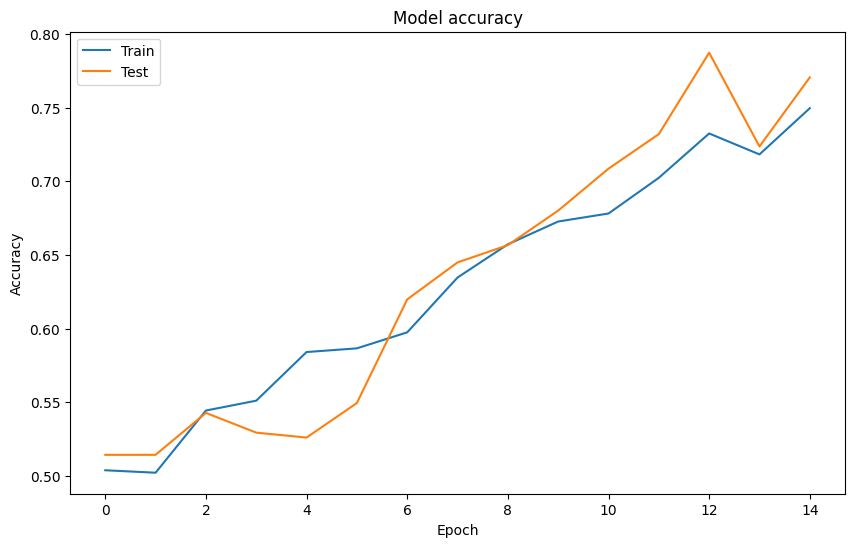

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


<Figure size 800x600 with 0 Axes>

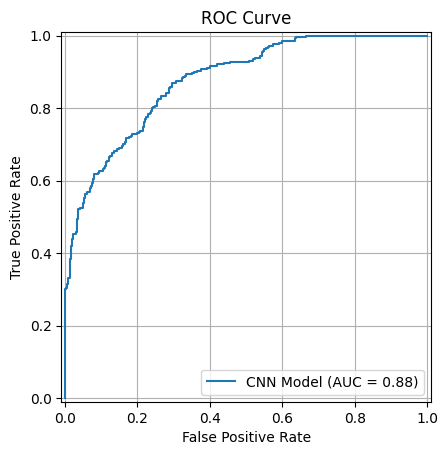

In [12]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, f1_score
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred_keras = model.predict(X_test).ravel()

# Calculate ROC curve and AUC
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr_keras, tpr=tpr_keras, roc_auc=auc_keras, estimator_name='CNN Model').plot()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [13]:
# Calculate F1 Score
# First, convert probabilities to binary predictions (threshold at 0.5)
y_pred_binary = (y_pred_keras > 0.5).astype(int)

f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7221


In [ ]:

from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
model = Sequential([
    Input(shape = (img_dim, img_dim, 3)),
    Conv2D(8, (3,3), activation='relu', padding='same'),
    Conv2D(8, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(4, activation = 'softmax')
])
